In [2]:
import xarray as xr
import numpy as np
import os
import optuna
from glob import glob
import tqdm


import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter
import seaborn as sb
from cycler import cycler

import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 'medium'
})

In [3]:
colors = {
    0.5: 'tab:blue',
    1.5: 'tab:red',
    2.5: 'tab:purple'
}

In [34]:
rerun = False

if not rerun:
    raise ValueError(
        '`rerun=False`. set `True` if you want to rerun (~12 min).'
    )

paths = glob(f'../logs/experiment_01/lightning_logs/version_*/predictions.nc')

iter_max = -1
path_max = -1
for p in tqdm.tqdm(paths):
    iter_len = len(xr.open_dataset(p).iter)
    if iter_len > iter_max:
        iter_max = iter_len
        path_max = p

ds_all = xr.open_dataset(path_max).q10
ds_all.values[:] = np.nan
ds_all = ds_all.expand_dims(
    {'q10_init': [0.5, 1.5, 2.5], 'dropout': [0.0, 0.2, 0.4], 'weight_decay': [0.0, 0.01, 0.1], 'rep': np.arange(10), 'use_ta': [0, 1]}).copy()

ds_counter = xr.open_dataset(paths[0]).q10.isel(iter=0).drop('iter').expand_dims(
    {'q10_init': [0.5, 1.5, 2.5], 'dropout': [0.0, 0.2, 0.4], 'weight_decay': [0.0, 0.01, 0.1], 'use_ta': [0, 1]}).astype('int').copy()
ds_counter.values[:] = 0

error_count = 0
for i, p in enumerate(tqdm.tqdm(paths)):

    try:
        ds = xr.open_dataset(p)
    except:
        error_count += 1
        continue

    weight_decay = ds.attrs['weight_decay']
    q10_init = ds.attrs['q10_init']
    dropout = ds.attrs['dropout']
    use_ta = bool(ds.attrs['use_ta'])

    rep = ds_counter.sel(q10_init=q10_init, dropout=dropout, weight_decay=weight_decay, use_ta=int(use_ta))

    if rep == 10:
        continue

    ds_all.loc[
        dict(
            q10_init=q10_init,
            dropout=dropout,
            weight_decay=weight_decay,
            use_ta=int(use_ta),
            rep=rep)
    ][:len(ds.q10.values)] = ds.q10.values

    ds_counter.loc[dict(q10_init=q10_init, dropout=dropout, weight_decay=weight_decay, use_ta=int(use_ta))] += 1

    if (ds_counter == 1).all().item():
        break

ds_all.to_netcdf('../logs/experiment_01/lightning_logs/predictions_grid.nc')

100%|██████████| 1002/1002 [00:40<00:00, 24.63it/s]


PermissionError: [Errno 13] Permission denied: b'/Net/Groups/BGI/people/bkraft/git/q10hybrid/logs/experiment_02/lightning_logs/predictions_grid.nc'

In [37]:
ds_all = xr.open_dataset('../logs/experiment_01/lightning_logs/predictions_grid2.nc').load()

In [38]:
ds = xr.open_dataset('/Net/Groups/BGI/people/bkraft/data/Synthetic4BookChap.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 157776)
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01T00:15:00 ... 2011-12-31T23:45:00
Data variables:
    sw_pot   (time) float64 ...
    dsw_pot  (time) float64 ...
    ta       (time) float64 ...
    reco     (time) float64 ...
    rb       (time) float64 ...

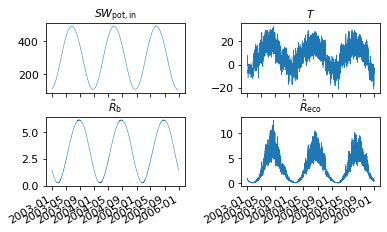

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(6, 3), sharex=True, gridspec_kw={'hspace': 0.35, 'wspace': 0.4})

plot_kwargs = dict(
    lw=0.5
)

ds.sw_pot.sel(time=slice('2003', '2005')).plot(ax=axes[0, 0], **plot_kwargs)
ds.ta.sel(time=slice('2003', '2005')).plot(ax=axes[0, 1], **plot_kwargs)
ds.rb.sel(time=slice('2003', '2005')).plot(ax=axes[1, 0], **plot_kwargs)
ds.reco.sel(time=slice('2003', '2005')).plot(ax=axes[1, 1], **plot_kwargs)

axes[0, 0].set_title(r'$\tilde{R}_b$')


for ax, title in zip(
        axes.flat,
        [r'$SW_\mathrm{pot, in}$', r'$T$', r'$\tilde{R}_\mathrm{b}$', r'$\tilde{R}_\mathrm{eco}$']):

    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.savefig(f'./plots/data.png', dpi=300, transparent=True, bbox_inches='tight')

In [39]:
df_all = ds_all.to_dataframe().reset_index()

In [40]:
def plot_grid(df, with_temp, transparent=False):
    plt.rcParams.update({
        'axes.titley': 0.8
    })
    df = df[df['use_ta']==int(with_temp)]
    g = sb.relplot(
        x='iter', y='q10', col='dropout', row='weight_decay', hue='q10_init', style='rep',
        data=df, kind='line', dashes=False, height=2, aspect=1.1, palette='colorblind', alpha=0.5)

    for i in range(g.axes.shape[0]):
        for j in range(g.axes.shape[1]):
            ax = g.axes[i, j]
            ax.axhline(1.5, ls=':', color='k', lw=1.4)

            if (i == 1) and (j == 0):
                ax.set_ylabel(r'$Q_{10}$')
            else:
                ax.set_ylabel('')

            if (i == 2) and (j == 1):
                ax.set_xlabel('Training iteration')
            else:
                ax.set_xlabel('')

    g.legend.remove()

    h, l = g.axes[0, 0].get_legend_handles_labels()

    g.axes[0, 1].legend(
        [Line2D([0], [0], color='k', ls=':', lw=1)] + h[1:4],
        [r'$Q_{10}$ true'] + l[1:4],
        frameon=False,
        ncol=4,
        title=r'$Q_{10}$ init',
        loc='lower center',
        bbox_to_anchor=(0.5, 1.1))

    for ax in g.axes.flatten():
        ax.set_title(ax.get_title().replace(' | ', '\n'))
        if transparent:
            ax.patch.set_facecolor('none')

    if not transparent:
        kwargs = dict(
            transparent=False,
            facecolor='w'
        )
    else: 
        kwargs = dict()

    #plt.savefig(f'./plots/q10_{"wi" if with_temp else "wo"}_ta.png', dpi=300, transparent=False, facecolor='w')
    g.savefig(f'./plots/q10_{"wi" if with_temp else "wo"}_ta.png', dpi=300, **kwargs)

    return g

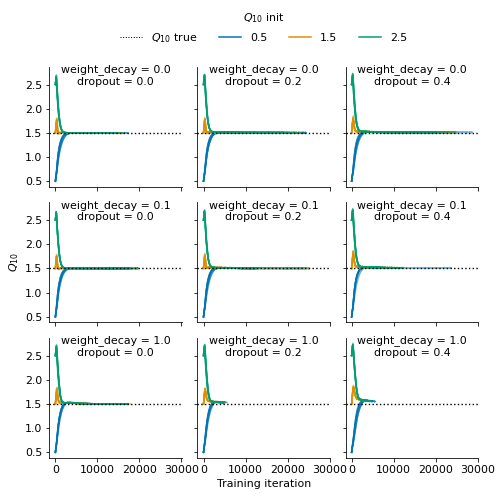

In [41]:
g = plot_grid(df_all, False, transparent=True)

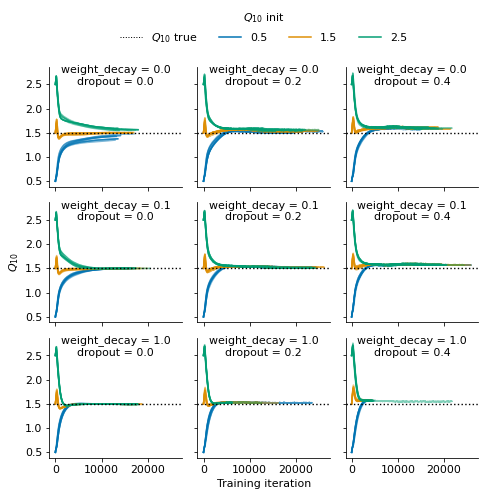

In [42]:
g = plot_grid(df_all, True, transparent=True)

In [45]:
study = optuna.study.load_study(study_name='q10hybrid', storage='sqlite:////Net/Groups/BGI/people/bkraft/git/q10hybrid/logs/experiment_01/optuna.db')
df = study.trials_dataframe()[[
    'value',
    'params_weight_decay',
    'params_q10_init',
    'params_dropout',
    'params_use_ta',
    'user_attrs_q10']]

In [46]:
df = df.rename(columns={
    'value': 'loss',
    'params_weight_decay': 'weight decay',
    'params_q10_init': 'Q10 init',
    'params_dropout': 'dropout',
    'user_attrs_q10': 'Q10',
    'params_use_ta': 'With temperature'
})
df

loss  weight decay  Q10 init  dropout  With temperature       Q10
0     0.000166           1.0       0.5      0.0             False  1.500506
1     0.000006           0.0       0.5      0.0              True  1.473302
2     0.002106           0.0       1.5      0.4              True  1.586569
3     0.000014           0.1       1.5      0.0             False  1.500511
4          NaN           0.0       0.5      0.4              True       NaN
...        ...           ...       ...      ...               ...       ...
1433  0.001592           0.1       1.5      0.2             False  1.504111
1434  0.000004           0.0       0.5      0.0              True  1.417854
1435  0.001592           0.1       1.5      0.2             False  1.504111
1436  0.001592           0.1       1.5      0.2             False  1.504111
1437  0.001592           0.1       1.5      0.2             False  1.504111

[1438 rows x 6 columns]

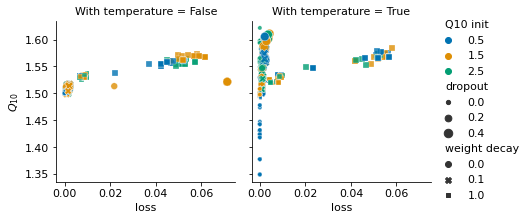

In [47]:
transparent = True

plt.rcParams.update({
    'axes.titley': 1.,
    'axes.titlelocation': 'center'
})

g = sb.relplot(x='loss', y='Q10', hue='Q10 init', size='dropout', col='With temperature', style='weight decay', data=df, palette='colorblind', alpha=0.8, height=3, aspect=1)

#x = np.linspace(0.005, 0.07, 100)

#g.axes[0, 1].plot(x, np.sqrt(x)*10.1)
#g.axes[0, 1].plot(x, np.sqrt(x)*1.6)

#ax = g.axes[0, 1]
#ax.plot(x, np.sqrt(x) * 2 + 1.1, color='k', alpha=0.5, ls='--')
#ax.plot(x, np.sqrt(x) * 3 + 1.5, color='k', alpha=0.5, ls='--')

#ax.text(0.98, 0.26, f'weight decay = 0.0',
#    horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
#ax.text(0.98, 0.68, f'weight decay = 0.01',
#    horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
#ax.text(0.05, 0.9, f'weight decay = 0.1',
#    horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

#g.axes[0, 0].axhline(1.5, ls=':', color='k', lw=1.4)
#g.axes[0, 1].axhline(1.5, ls=':', color='k', lw=1.4)

g.axes[0, 0].set_ylabel(r'$Q_{10}$')

if transparent:
    for ax in g.axes.flatten():
        ax.patch.set_facecolor('none')
    kwargs = dict()
else:
    kwargs = dict(
        transparent=False,
        facecolor='w'
    )

#g.axes[0, 0].set_xlim(0, 0.006)
#g.savefig(f'./plots/q10_interactions.png', dpi=300, **kwargs)

In [27]:
from joblib import parallel_backend

In [28]:
with parallel_backend('multiprocessing'):  # Overrides `prefer="threads"` to use multi-processing.
    print(1)

1


In [21]:
os.makedirs('./plots', exist_ok=True)

In [23]:
import shutil

In [26]:
shutil.rmtree('./test', ignore_errors=False)

FileNotFoundError: [Errno 2] No such file or directory: './test'

In [30]:
import torch

In [33]:
available_gpus = [i for i in range(torch.cuda.device_count())]
available_gpus

[0, 1, 2, 3, 4, 5, 6, 7]

In [34]:
torch.cuda.device_count()

8

In [52]:
num_jobs = np.arange(10)

In [53]:
num_jobs % 8

array([0, 1, 2, 3, 4, 5, 6, 7, 0, 1])

In [ ]:
print('test')
print('d')